## Dataset information as per Kaggle (https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)

1. **train.csv** - The training set.
   * `Id` Unique identifier for each observation.
   * `AB-GL` Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
   * `Class` A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
2. **test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
3. **greeks.csv** - Supplemental metadata, only available for the training set.
   * `Alpha` Identifies the type of age-related condition, if present.
     * `A` No age-related condition. Corresponds to class 0.
     * `B`, `D`, `G` The three age-related conditions. Correspond to class 1.
   * `Beta`, `Gamma`, `Delta` Three experimental characteristics.
   * `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [19]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf, keras, and sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Unused atm
from sklearn.decomposition import KernelPCA

# Stats library
import statsmodels.api as sm

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [51]:
greeks = pd.read_csv('../data/greeks.csv')
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

greeks.columns = map(str.lower, greeks.columns)
test.columns = map(str.lower, test.columns)
train.columns = map(str.lower, train.columns)

print('Shape of greeks df:', greeks.shape)
print('Shape of test df:', test.shape)
print('Shape of train df:', train.shape)

# Merge train and greeks to get all columns in the same DataFrame
df = pd.merge(train, greeks, on='id')

Shape of greeks df: (617, 6)
Shape of test df: (5, 57)
Shape of train df: (617, 58)


In [52]:
# Encoded EJ as 0 or 1 so it could be used in tSNE
df['ej'].replace(to_replace=['A', 'B'], value = [0, 1], inplace=True)

# Multiclass target variable
target_variable_multiclass = df['alpha']

# Binary target variable

features_columns = list(df.columns)
for x in ['class', 'id', 'alpha', 'beta', 'gamma', 'delta', 'epsilon']:
    features_columns.remove(x)

target_variable = df['class']
df.drop(['class', 'id', 'alpha', 'beta', 'gamma', 'delta', 'epsilon'], axis=1, inplace=True)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(df))
features_variable.columns = features_columns

In [54]:
def feature_reduction(method, num_features, data_split):
    if method == 'pca':
        # Split into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(X_train)

        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)

        # PCA
        pca = PCA(n_components = num_features)
        pca.fit(X_train_std)
        X_train_pca = pd.DataFrame(pca.transform(X_train_std))
        X_test_pca = pd.DataFrame(pca.transform(X_test_std))

        return X_train_pca, X_test_pca, y_train, y_test
    
    elif method == 'tsne':
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(features_variable)
        features_variable_std = sc.transform(features_variable)

        tsne = TSNE(n_components=num_features, random_state=0, perplexity=50, n_iter=5000, method = 'exact')

        # Calculate the 12 features via tSNE model
        features_variable_tsne = pd.DataFrame(tsne.fit_transform(features_variable_std))

        #Split into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(features_variable_tsne, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        return X_train, X_test, y_train, y_test


In [56]:
X_train, X_test, y_train, y_test = feature_reduction('pca', 10, 0.3)

In [18]:
display(X_train.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train.shape)

,0,1,2,3,4,5,6,7,8,9
222,3.946346,-12.885464,-0.509796,-0.384011,1.873318,-0.807906,3.888238,10.464826,-1.165919,0.751666
255,1.296616,-4.477819,2.941146,-0.751147,-2.973345,2.887574,-8.747878,0.076179,-8.710191,-4.963955
420,4.398509,0.171529,6.032077,-10.551544,-2.683525,2.904293,6.558273,0.986148,-1.175675,0.322910
344,-0.541987,5.254478,-1.319121,-5.820622,2.456019,1.528531,-12.379393,-0.686732,4.326978,-0.366931
203,-2.110267,-0.509143,-6.949670,6.898934,-0.383837,1.604165,-10.325000,-5.249002,-2.693690,3.928116


(617, 56)

(431, 10)

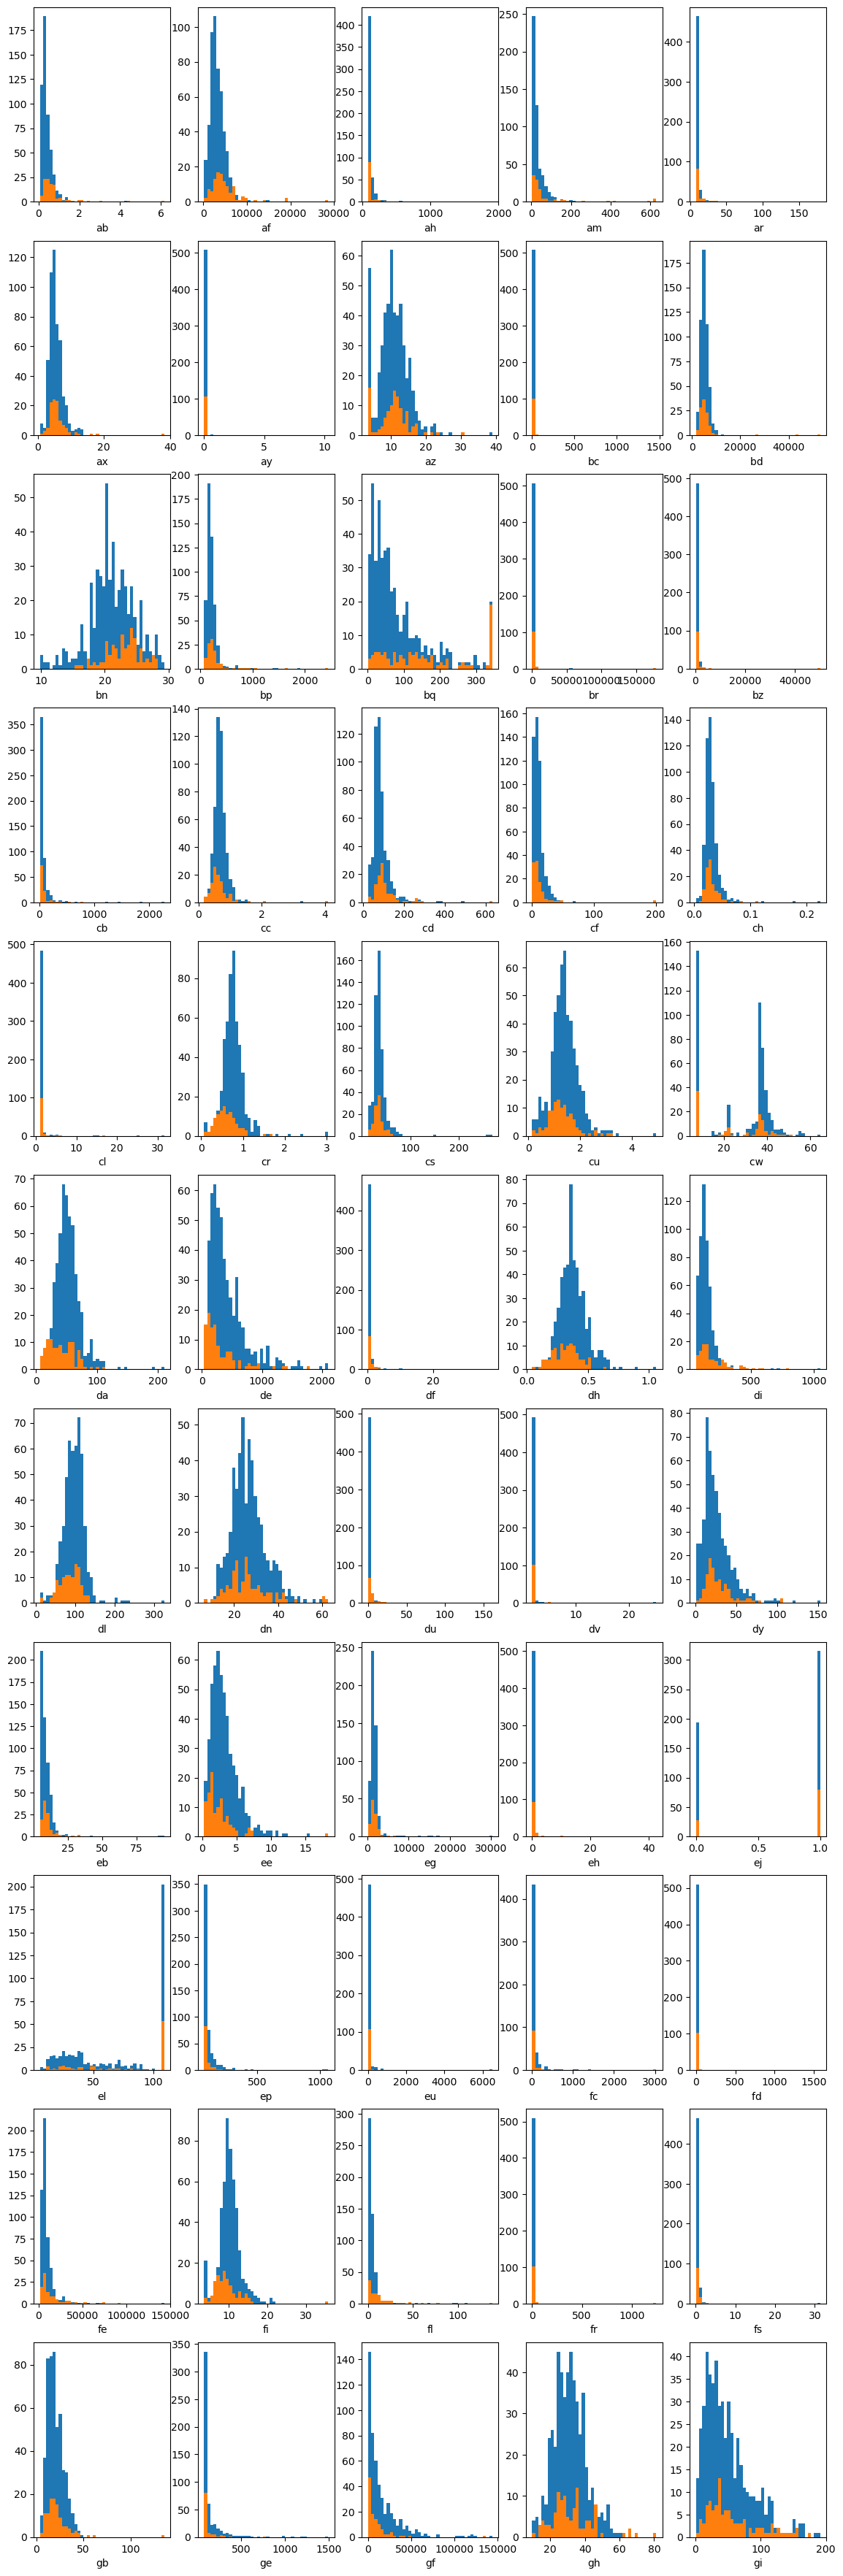

In [58]:
##########################################
### This is on 100% of the data, needs ###
### needs to be on 70% of data.        ###
##########################################

df_train = pd.DataFrame(features_variable).join(target_variable)
columns = list(df_train.columns)
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(14,45))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    # if(columns[idx] in ['EJ','Beta','Gamma','Delta']):
    #     no_disease = df_train[df_train['Alpha']==0][columns[idx]]
    #     disease = df_train[df_train['Alpha']!=0][columns[idx]]
    #     ax.hist(no_disease)
    #     ax.hist(disease)
    # else:
    no_disease = df_train[df_train['class']==0][columns[idx]]
    disease = df_train[df_train['class']!=0][columns[idx]]
    bins=np.histogram(np.hstack((no_disease,disease)), bins=40)[1]
    ax.hist(no_disease, bins)
    ax.hist(disease, bins)
    # set xlabel
    ax.set_xlabel(columns[idx])